In [33]:
# ! kaggle competitions download -c titanic

In [34]:
# ! unzip titanic.zip

In [35]:
# ! pwd

In [36]:
# ! pip install optuna

In [60]:
import pandas as pd
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
import numpy as np

X_train = pd.read_csv('/opt/notebooks/kaggle/Kaggle-competitions/titanic/train.csv')
X_test = pd.read_csv('/opt/notebooks/kaggle/Kaggle-competitions/titanic/test.csv')

y_train = X_train['Survived']
X_train.drop(columns='Survived', inplace=True)

train_df = pd.concat([X_train, X_test], ignore_index=True)
train_df = train_df.drop(columns=['Name', 'Ticket', 'Cabin'])
train_df['Fare'].fillna(train_df['Fare'].mean(), inplace=True)

In [38]:
train_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
1304,1305,3,male,NaN,0,0,8.0500,S
1305,1306,1,female,39.0,0,0,108.9000,C
1306,1307,3,male,38.5,0,0,7.2500,S
1307,1308,3,male,NaN,0,0,8.0500,S


Предскажем пропущенный данные в возрасте

In [39]:
test_age = train_df[train_df['Age'].isna()]
train_age = train_df[train_df['Age'].notna()]

In [40]:
# обучаем модель на данных, где возраст не пропущен
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = train_age[['Pclass', 'SibSp', 'Parch', 'Fare']]
y = train_age['Age']
X['Fare'].fillna(X['Fare'].mean(), inplace=True)

# X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['Pclass', 'SibSp', 'Parch', 'Fare']]).astype(int)
train_df.loc[train_df['Age'].isna(), 'Age'] = predicted_ages

/tmp/ipykernel_53313/1819819962.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
train_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
1304,1305,3,male,28.0,0,0,8.0500,S
1305,1306,1,female,39.0,0,0,108.9000,C
1306,1307,3,male,38.5,0,0,7.2500,S
1307,1308,3,male,28.0,0,0,8.0500,S


In [42]:
train_df['solo'] = ((train_df['SibSp'] != 0) | (train_df['Parch'] != 0)).astype(int)

In [43]:
train_df['ageGroup'] = pd.cut(train_df['Age'], bins=[0, 12, 20, 40, 60, 80], labels=False)

In [44]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

In [45]:
train_df['FareGroup'] = pd.cut(train_df['Fare'], bins=[-0.1, 7, 14, 21, 30, 1000], labels=False).astype(int)

In [46]:
train_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,solo,ageGroup,FamilySize,FareGroup
0,1,3,male,22.0,1,0,7.2500,S,1,2,2,1
1,2,1,female,38.0,1,0,71.2833,C,1,2,2,4
2,3,3,female,26.0,0,0,7.9250,S,0,2,1,1
3,4,1,female,35.0,1,0,53.1000,S,1,2,2,4
4,5,3,male,35.0,0,0,8.0500,S,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,male,28.0,0,0,8.0500,S,0,2,1,1
1305,1306,1,female,39.0,0,0,108.9000,C,0,2,1,4
1306,1307,3,male,38.5,0,0,7.2500,S,0,2,1,1
1307,1308,3,male,28.0,0,0,8.0500,S,0,2,1,1


In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   object 
 3   Age          1309 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1309 non-null   float64
 7   Embarked     1307 non-null   object 
 8   solo         1309 non-null   int64  
 9   ageGroup     1309 non-null   int64  
 10  FamilySize   1309 non-null   int64  
 11  FareGroup    1309 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 122.8+ KB


In [48]:
train_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,solo,ageGroup,FamilySize,FareGroup
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.749939,0.498854,0.385027,33.295479,0.396486,1.942704,1.883881,2.148969
std,378.020061,0.837836,13.363519,1.041658,0.865560,51.738879,0.489354,0.840809,1.583639,1.321994
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,328.000000,2.000000,22.000000,0.000000,0.000000,7.895800,0.000000,2.000000,1.000000,1.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,2.000000,1.000000,2.000000
75%,982.000000,3.000000,37.000000,1.000000,0.000000,31.275000,1.000000,2.000000,2.000000,4.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,4.000000,11.000000,4.000000


In [49]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

In [50]:
train_df['Sex'] = train_df['Sex'].astype('category')
train_df['Embarked'] = train_df['Embarked'].astype('category')
train_df['ageGroup'] = train_df['ageGroup'].astype('category')
train_df['FareGroup'] = train_df['FareGroup'].astype('category')
train_df['solo'] = train_df['solo'].astype('category')
train_df['Pclass'] = train_df['Pclass'].astype('category')
train_df['FamilySize'] = train_df['FamilySize'].astype('category')
train_df['SibSp'] = train_df['SibSp'].astype('category')
train_df['Parch'] = train_df['Parch'].astype('category')

In [51]:
X = train_df[:X_train.shape[0]]
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=['Sex', 'Embarked', 'ageGroup', 'FareGroup', 'solo', 'Pclass', 'FamilySize', 'SibSp', 'Parch'],
        iterations=trial.suggest_int("iterations", 500, 2000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 2, 4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        task_type='CPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [58]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=13, multivariate=True)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study.optimize(objective, n_trials=150, show_progress_bar=True, n_jobs=-1)

/opt/conda/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.



  0%|          | 0/150 [00:00<?, ?it/s]

In [59]:
from optuna.visualization import plot_slice

plot_slice(study)

In [ ]:
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score
# import numpy as np

# y = train_df['Survived']
# X = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# classifier = CatBoostClassifier(
#     n_estimators=1000,
#     depth=2,
#     loss_function='Logloss',
#     verbose=False,
#     task_type='GPU',
#     devices='0:7',
#     cat_features=['Sex', 'Embarked', 'ageGroup', 'FareGroup', 'solo', 'Pclass', 'FamilySize', 'SibSp', 'Parch'],
#     eval_metric='Accuracy'
# )
# classifier.grid_search({'learning_rate': np.linspace(0.01, 0.1, 10),
#                         'l2_leaf_reg': np.linspace(0, 5, 10)},
#                        X_train, y_train, cv=5, plot=True, refit=True, verbose=False)

In [ ]:
# X_train = train_df[:X_train.shape[0]]
# X_test = train_df[X_train.shape[0]:]
# X_train

In [ ]:
# from catboost import CatBoostClassifier
# from sklearn.metrics import accuracy_score

# X_train = train_df[:X_train.shape[0]]
# X_test = train_df[X_train.shape[0]:]

# classifier = CatBoostClassifier(
#     n_estimators=1000,
#     depth=2,
#     learning_rate=0.01,
#     l2_leaf_reg=0.05263157895,
#     loss_function='Logloss',
#     verbose=False,
#     cat_features=['Sex', 'Embarked', 'ageGroup', 'FareGroup', 'solo', 'Pclass', 'FamilySize', 'SibSp', 'Parch'],
#     eval_metric='Accuracy',
# )

# X_train

In [ ]:
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# X_test['Survived'] = y_pred

In [ ]:
# X_test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

In [ ]:
# ! kaggle competitions submit -c titanic -f submission.csv -m "first attemp"

In [ ]:
# попробуем применить случайный лес
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# используем one-hot encoding для категориальных признаков

from sklearn.preprocessing import OneHotEncoder

# X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

encoder = OneHotEncoder(sparse=False)
X_encoded = encoder.fit_transform(train_df[['Sex', 'Embarked']])
encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['Sex', 'Embarked']))
train_df = train_df.drop(columns=['Sex', 'Embarked'])
train_df = pd.concat([train_df, encoded_df], axis=1)

X_train = train_df[:X_train.shape[0]]
X_test = train_df[X_train.shape[0]:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=10000, max_depth=10, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [ ]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,solo,ageGroup,FamilySize,FareGroup,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
623,624,3,21.0,0,0,7.8542,0,2,1,1,0.0,1.0,0.0,0.0,1.0
624,625,3,21.0,0,0,16.1000,0,2,1,2,0.0,1.0,0.0,0.0,1.0
625,626,1,61.0,0,0,32.3208,0,4,1,4,0.0,1.0,0.0,0.0,1.0
626,627,2,57.0,0,0,12.3500,0,3,1,1,0.0,1.0,0.0,1.0,0.0
627,628,1,21.0,0,0,77.9583,0,2,1,4,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,3,28.0,0,0,8.0500,0,2,1,1,0.0,1.0,0.0,0.0,1.0
1305,1306,1,39.0,0,0,108.9000,0,2,1,4,1.0,0.0,1.0,0.0,0.0
1306,1307,3,38.5,0,0,7.2500,0,2,1,1,0.0,1.0,0.0,0.0,1.0
1307,1308,3,28.0,0,0,8.0500,0,2,1,1,0.0,1.0,0.0,0.0,1.0


In [ ]:
X_test['Survived'] = y_pred
X_test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

/tmp/ipykernel_53313/3428381318.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# ! kaggle competitions submit -c titanic -f submission.csv -m "second attemp"

100%|██████████████████████████████████████| 4.34k/4.34k [00:00<00:00, 7.07kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [313]:
import pandas as pd
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve, auc
from local_manipulations import *

In [273]:
df = pd.read_csv('train.csv')
df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in df.columns]

target = df['survived']
df = df.drop(columns='survived')

df.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [274]:
df.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [275]:
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)

Заменим пропуски в возрасте используя lgb

In [276]:
test_age = df[df['age'].isna()]
train_age = df[df['age'].notna()]

X = train_age[['pclass', 'sibsp', 'parch', 'fare']]
y = train_age['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgb_tr = lgb.Dataset(X_train, y_train)
params = {'objective': 'regression', 'metric': 'l1', 'eta': 0.01, 'verbosity': -1}

model = lgb.train(
    params, lgb_tr, num_boost_round=1000,
    valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=100)]
)

[100]	train's l1: 9.97407
[200]	train's l1: 9.40305
[300]	train's l1: 9.13241
[400]	train's l1: 8.96947
[500]	train's l1: 8.84653
[600]	train's l1: 8.75382
[700]	train's l1: 8.67308
[800]	train's l1: 8.60358
[900]	train's l1: 8.54522
[1000]	train's l1: 8.48512


In [277]:
pred_median = [y_train.median()] * y_test.shape[0]
print(mean_absolute_error(y_test, pred_median), mean_squared_error(y_test, pred_median))

10.55153488372093 184.86193674418604


In [278]:
pred_lgb = model.predict(X_test)
print(mean_absolute_error(y_test, pred_lgb), mean_squared_error(y_test, pred_lgb))

9.259582954994187 142.94308207120142


In [279]:
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X_train, y_train)
pred_rf = model.predict(X_test)
print(mean_absolute_error(y_test, pred_rf), mean_squared_error(y_test, pred_rf))

8.931501091145135 134.43816702222912


При использовании rf получаем качество лучше, чем подставление медианы или использовании lgb. Поэтому используем rf для замены пропусков в возрасте

In [280]:
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=42)

In [281]:
predicted_ages = model.predict(test_age[['pclass', 'sibsp', 'parch', 'fare']]).astype(int)
df.loc[df['age'].isna(), 'age'] = predicted_ages

In [282]:
df.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         0
dtype: int64

Добавим новые фичи

In [283]:
df['familysize'] = df['sibsp'] + df['parch'] + 1
# df['isalone'] = 1
# df['isalone'].loc[df['familysize'] > 1] = 0
# df['farebin'] = pd.qcut(df['fare'], 4, labels=False)
# df['agebin'] = pd.cut(df['age'].astype(int), 5, labels=False)
df['title'] = df['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

In [284]:
df.drop(columns=['name', 'ticket', 'cabin', 'passengerid'], inplace=True)
df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,familysize,title
0,3,male,22.0,1,0,7.2500,S,2,Mr
1,1,female,38.0,1,0,71.2833,C,2,Mrs
2,3,female,26.0,0,0,7.9250,S,1,Miss
3,1,female,35.0,1,0,53.1000,S,2,Mrs
4,3,male,35.0,0,0,8.0500,S,1,Mr


In [285]:
df['sex'] = df['sex'].astype('category')
df['embarked'] = df['embarked'].astype('category')
df['title'] = df['title'].astype('category')

In [286]:
# n_val = 100
# X_train, y_train = df.iloc[:-n_val], target.iloc[:-n_val]
# X_test, y_test = df.iloc[-n_val:], target.iloc[-n_val:]

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

In [287]:
def plot_scores(model, X_tr, y_tr, X_val, y_val):
    y_pred_tr_expit = model.predict(X_tr)
    y_pred_tr_raw = model.predict(X_tr, raw_score=True)
    y_pred_val_expit = model.predict(X_val)
    y_pred_val_raw = model.predict(X_val, raw_score=True)

    mosaic = [
        ['tr_expit', 'tr_raw'],
        ['val_expit', 'val_raw'],
        ['sex=male. raw', 'sex=female. raw']
    ]
        
    fig, ax = plt.subplot_mosaic(mosaic, figsize=(15, 10))
    for key in ax:
        ax[key].set_title(key, fontsize=15)

    sns.histplot(x=y_pred_tr_expit, hue=y_tr, bins=33, ax=ax['tr_expit'])
    sns.histplot(x=y_pred_tr_raw, hue=y_tr, bins=33, ax=ax['tr_raw'])
    sns.histplot(x=y_pred_val_expit, hue=y_val, bins=33, ax=ax['val_expit'])
    sns.histplot(x=y_pred_val_raw, hue=y_val, bins=33, ax=ax['val_raw'])

    for value in X_val.sex.unique():
        cond = X_val.sex == value
        sns.histplot(x=y_pred_val_raw[cond], hue=y_val[cond], bins=33, ax=ax[f'sex={value}. raw'])
    
    fig.tight_layout()
    plt.show()

[50]	train's cross_entropy: 0.499629
[100]	train's cross_entropy: 0.419965
[150]	train's cross_entropy: 0.370471
[200]	train's cross_entropy: 0.339283
[250]	train's cross_entropy: 0.316063
[300]	train's cross_entropy: 0.293732
[350]	train's cross_entropy: 0.274988
[400]	train's cross_entropy: 0.260109


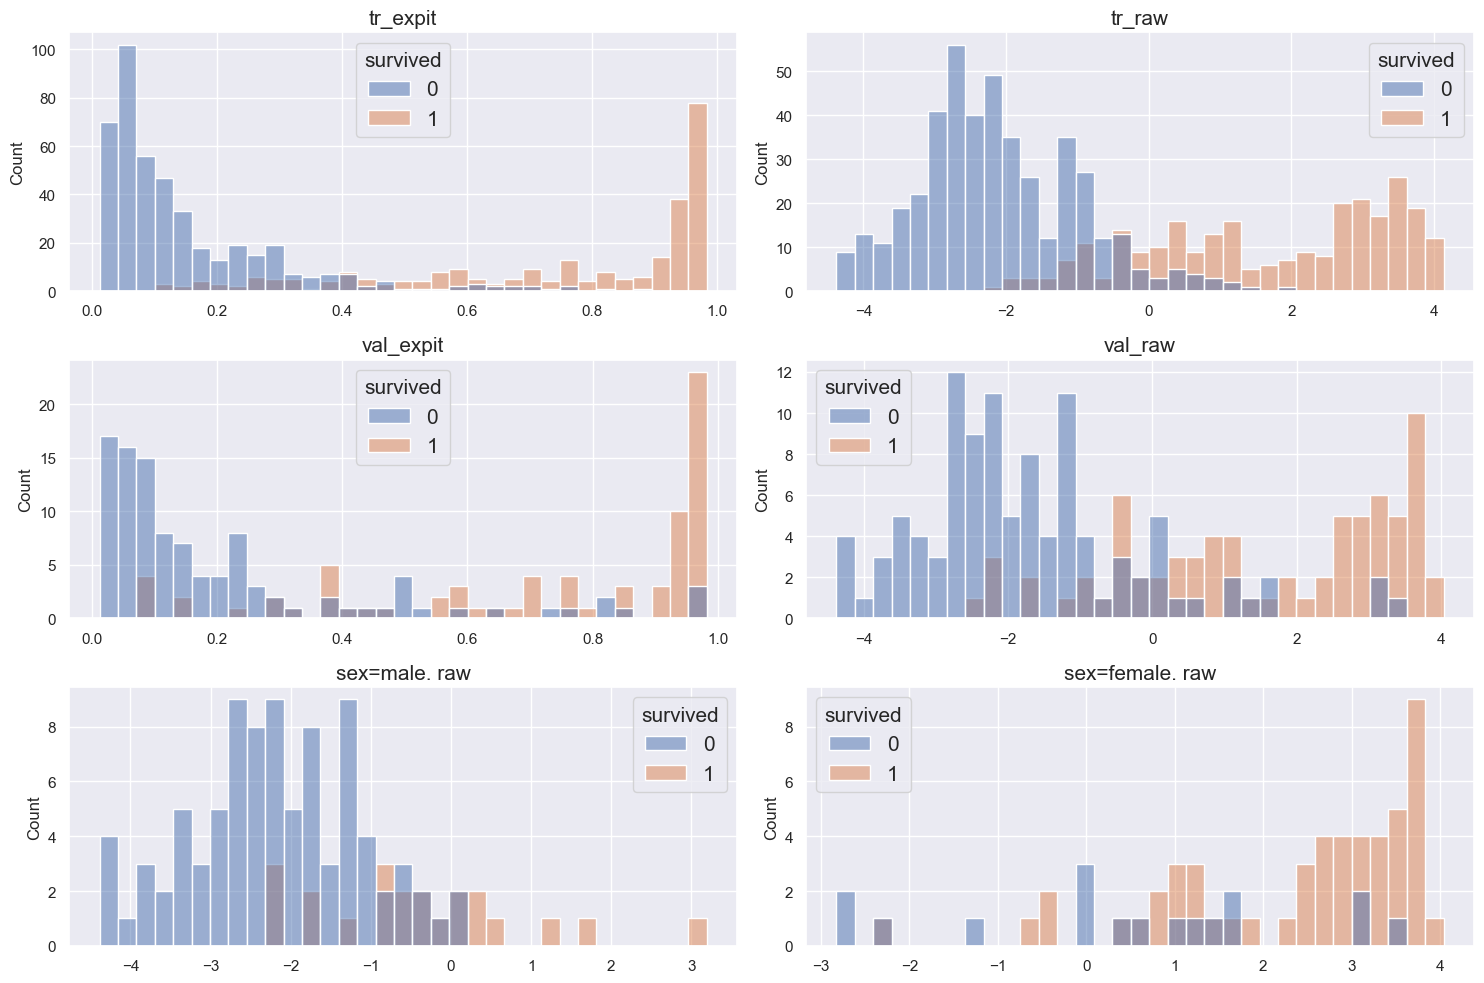

In [296]:
lgb_tr = lgb.Dataset(X_train, y_train)
params = {'objective': 'binary', 'metric': 'cross_entropy', 'eta': 0.01, 'verbosity': -1}

model = lgb.train(
    params, lgb_tr, num_boost_round=400,
    valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=50)]
)

plot_scores(model, X_train, y_train, X_test, y_test)

In [297]:
def train_model_get_t(X_tr, y_tr, params=None):
    lgb_tr = lgb.Dataset(X_tr, y_tr)
    if params is None:
        params = {'objective': 'binary', 'metric': 'binary_logloss', 'eta': 0.01, 'verbosity': -1}

    model = lgb.train(
        params, lgb_tr, num_boost_round=400,
        valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=50)]
    )

    t = model.trees_to_dataframe()
    t['abs_value'] = np.abs(t.value)
    return t

t = train_model_get_t(X_train, y_train)
t

[50]	train's binary_logloss: 0.499629
[100]	train's binary_logloss: 0.419965
[150]	train's binary_logloss: 0.370471
[200]	train's binary_logloss: 0.339283
[250]	train's binary_logloss: 0.316063
[300]	train's binary_logloss: 0.293732
[350]	train's binary_logloss: 0.274988
[400]	train's binary_logloss: 0.260109


,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count,abs_value
0,0,1,0-S0,0-S2,0-S1,None,sex,208.966995,1,==,right,None,-0.504838,0.000000,712,0.504838
1,0,2,0-S2,0-L0,0-S4,0-S0,age,24.151800,6.5,<=,left,None,-0.512937,109.616000,467,0.512937
2,0,3,0-L0,None,None,0-S2,None,NaN,None,None,None,None,-0.491826,5.163931,22,0.491826
3,0,3,0-S4,0-S6,0-S7,0-S2,pclass,13.734100,1.5,<=,left,None,-0.513981,104.452000,445,0.513981
4,0,4,0-S6,0-L3,0-S14,0-S4,age,2.321220,38.5,<=,left,None,-0.506829,21.359900,91,0.506829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21517,399,6,399-S8,399-S9,399-L9,399-S7,pclass,1.171130,2.5,<=,left,None,0.000135,3.084670,50,0.000135
21518,399,7,399-S9,399-L8,399-L10,399-S8,fare,0.477929,39.3,<=,left,None,0.005251,1.825730,42,0.005251
21519,399,8,399-L8,None,None,399-S9,None,NaN,None,None,None,None,0.000243,0.932323,17,0.000243
21520,399,8,399-L10,None,None,399-S9,None,NaN,None,None,None,None,0.010478,0.893403,25,0.010478


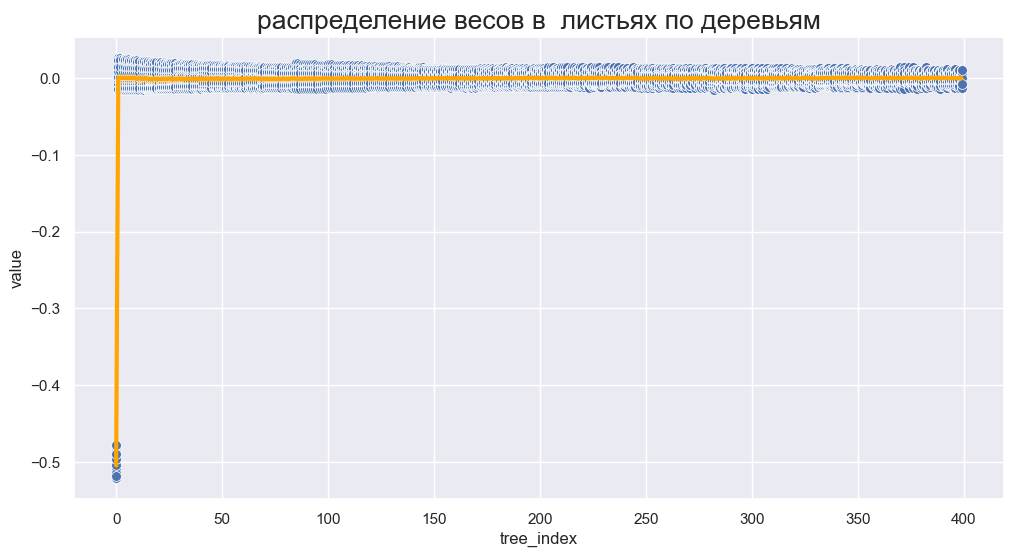

In [298]:
plt.title('распределение весов в  листьях по деревьям', fontsize=19)
sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='value', s=50)
sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='value',  color='orange', lw=3)
plt.gcf().set_size_inches(12, 6)

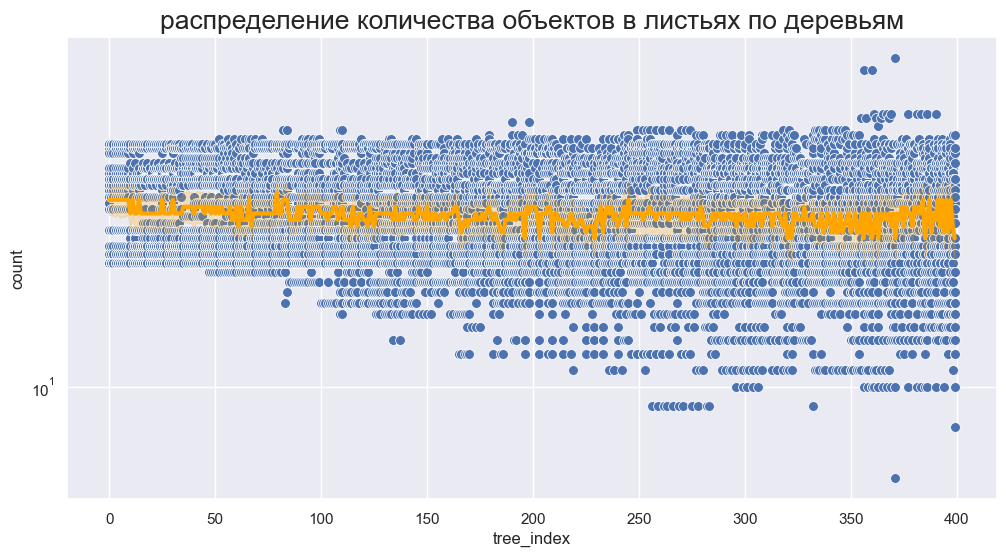

In [299]:
plt.title('распределение количества объектов в листьях по деревьям', fontsize=19)
sns.scatterplot(t.query('split_gain.isnull()'), x='tree_index', y='count', s=50)
sns.lineplot(t.query('split_gain.isnull()'), x='tree_index', y='count',  color='orange', lw=3)
plt.yscale('log')
plt.gcf().set_size_inches(12, 6)

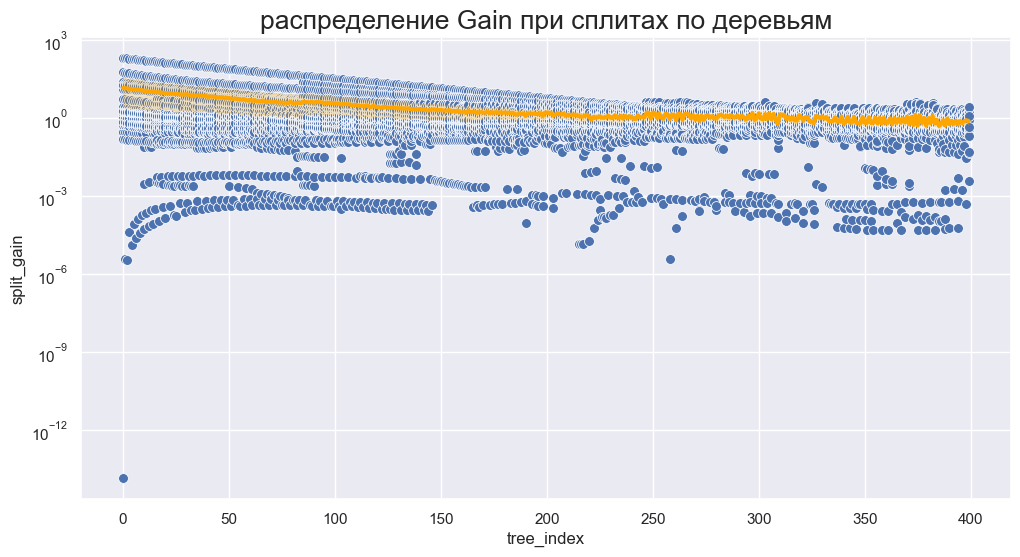

In [300]:
plt.title('распределение Gain при сплитах по деревьям', fontsize=19)
sns.scatterplot(t, x='tree_index', y='split_gain', s=50)
sns.lineplot(t, x='tree_index', y='split_gain',  color='orange', lw=3)
plt.yscale('log')
plt.gcf().set_size_inches(12, 6)

[50]	train's binary_logloss: 0.499629
[100]	train's binary_logloss: 0.419965
[150]	train's binary_logloss: 0.370471
[200]	train's binary_logloss: 0.339283
[250]	train's binary_logloss: 0.316063
[300]	train's binary_logloss: 0.293732
[350]	train's binary_logloss: 0.274988
[400]	train's binary_logloss: 0.260109


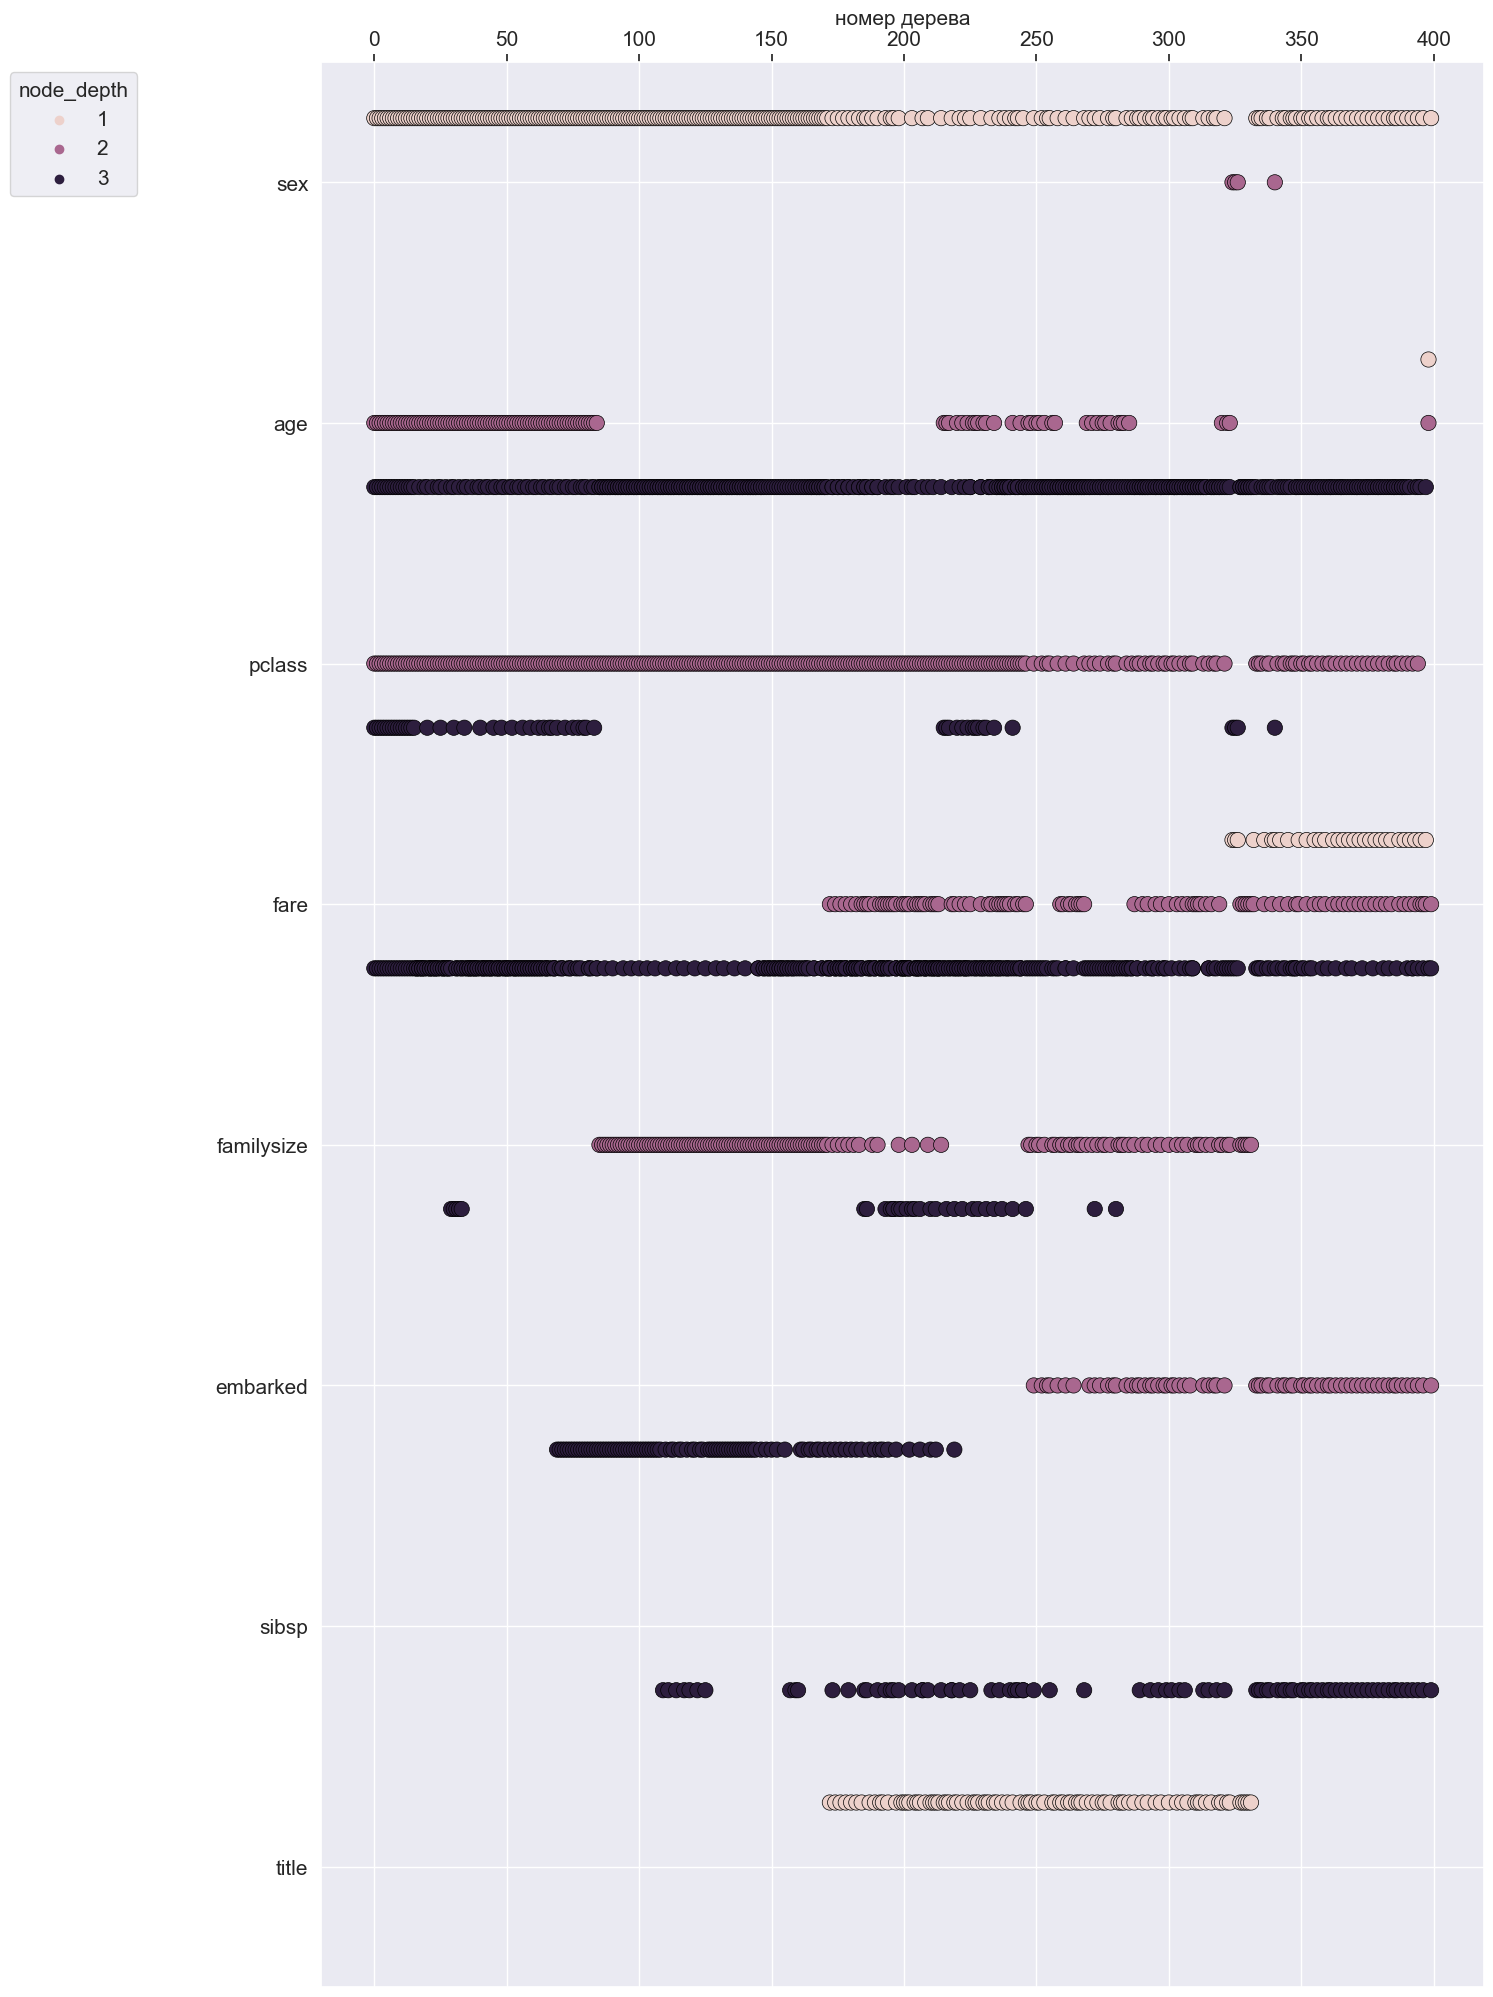

In [301]:
t = train_model_get_t(X_train, y_train)
plot_tree_info(t)

In [302]:
plot_feature_info(t)

In [309]:
params = {'objective': 'binary', 'metric': 'cross_entropy', 'eta': 0.01, 'verbosity': -1}

model = lgb.train(
    params, lgb_tr, num_boost_round=400,
    valid_sets=[lgb_tr], valid_names=['train'], callbacks=[lgb.log_evaluation(period=50)]
)

[50]	train's cross_entropy: 0.499629
[100]	train's cross_entropy: 0.419965
[150]	train's cross_entropy: 0.370471
[200]	train's cross_entropy: 0.339283
[250]	train's cross_entropy: 0.316063
[300]	train's cross_entropy: 0.293732
[350]	train's cross_entropy: 0.274988
[400]	train's cross_entropy: 0.260109


In [320]:
pred = model.predict(X_test)
roc_auc_score(y_test, pred)

0.9015444015444015

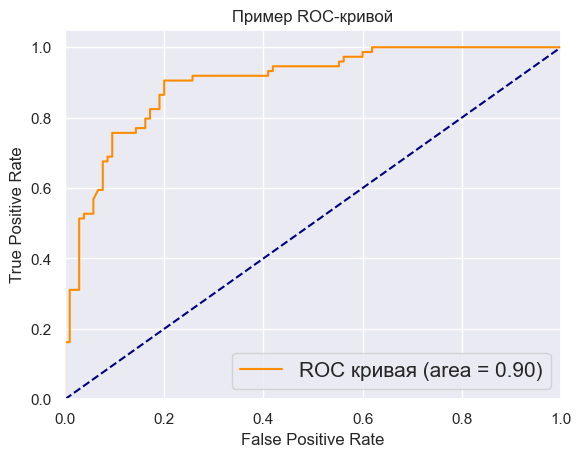

In [314]:
fpr, tpr, treshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [328]:
pred = model.predict(X_test)
pred = [1 if p > 0.35 else 0 for p in pred]
accuracy_score(y_test, pred)

0.8324022346368715

In [54]:
train_df = pd.concat([X_train, X_test], ignore_index=True)
train_df = train_df.drop(columns=['Ticket', 'Cabin'])
train_df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

test_age = train_df[train_df['Age'].isna()]
train_age = train_df[train_df['Age'].notna()]
# обучаем модель на данных, где возраст не пропущен

X = train_age[['Pclass', 'SibSp', 'Parch', 'Fare']]
y = train_age['Age']

# X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['Pclass', 'SibSp', 'Parch', 'Fare']]).astype(int)
train_df.loc[train_df['Age'].isna(), 'Age'] = predicted_ages

In [55]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

In [56]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = 1
train_df['IsAlone'].loc[train_df['FamilySize'] > 1] = 0
train_df['FareBin'] = pd.qcut(train_df['Fare'], 4, labels=False)
train_df['AgeBin'] = pd.cut(train_df['Age'].astype(int), 5, labels=False)

/tmp/ipykernel_221872/167332781.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
train_df['Title'] = train_df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
stat_min = 10
title_names = (train_df['Title'].value_counts() < stat_min)
train_df['Title'] = train_df['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train_df['Title'].value_counts())

Mr        757
Miss      260
Mrs       197
Master     61
Misc       34
Name: Title, dtype: int64


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Embarked     1309 non-null   object 
 9   FamilySize   1309 non-null   int64  
 10  IsAlone      1309 non-null   int64  
 11  FareBin      1309 non-null   int64  
 12  AgeBin       1309 non-null   int64  
 13  Title        1309 non-null   object 
dtypes: float64(2), int64(8), object(4)
memory usage: 143.3+ KB


In [59]:
train_df.drop(columns=['Name'], inplace=True)

In [60]:
train_df['Sex'] = train_df['Sex'].astype('category')
train_df['Embarked'] = train_df['Embarked'].astype('category')
train_df['Title'] = train_df['Title'].astype('category')
train_df['IsAlone'] = train_df['IsAlone'].astype('category')
train_df['Pclass'] = train_df['Pclass'].astype('category')
train_df['FamilySize'] = train_df['FamilySize'].astype('category')
train_df['SibSp'] = train_df['SibSp'].astype('category')
train_df['Parch'] = train_df['Parch'].astype('category')

In [61]:
X = train_df[:X_train.shape[0]]
y = y_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=['Sex', 'Embarked', 'FareBin', 'AgeBin', 'Title', 'IsAlone', 'Pclass', 'FamilySize', 'SibSp', 'Parch'],
        iterations=trial.suggest_int("iterations", 500, 2000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 2, 4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        task_type='CPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=70, n_ei_candidates=13, multivariate=True)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study.optimize(objective, n_trials=300, show_progress_bar=True, n_jobs=-1)

/opt/conda/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning:

``multivariate`` option is an experimental feature. The interface can change in the future.



  0%|          | 0/300 [00:00<?, ?it/s]

In [64]:
from optuna.visualization import plot_slice

plot_slice(study)

In [65]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [66]:
study.best_params

{'iterations': 723,
 'learning_rate': 0.08620134007004433,
 'depth': 4,
 'l2_leaf_reg': 0.1974080708861932,
 'bootstrap_type': 'Bayesian',
 'random_strength': 0.5693541230488852,
 'bagging_temperature': 1.6762236111624398,
 'od_type': 'Iter',
 'od_wait': 49}

In [68]:
X_test = train_df[X.shape[0]:]

model = CatBoostClassifier(**study.best_params, cat_features=['Sex', 'Embarked', 'FareBin', 'AgeBin', 'Title', 'IsAlone', 'Pclass', 'FamilySize', 'SibSp', 'Parch'], verbose=False)
model.fit(X, y)
pred = model.predict(X_test)

In [74]:
X_test['Survived'] = pred
X_test[['PassengerId', 'Survived']].to_csv('/opt/notebooks/kaggle/Kaggle-competitions/titanic/submission.csv', index=False)

/tmp/ipykernel_221872/1388606950.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
! kaggle competitions submit -c titanic -f /opt/notebooks/kaggle/Kaggle-competitions/titanic/submission.csv -m "catboost and optuna"

^C
User cancelled operation


In [276]:
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve, auc

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [277]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in df.columns]
test_df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in test_df.columns]

df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [279]:
df.isna().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [280]:
df.drop(columns=['passengerid'], inplace=True)
test_passengerid = test_df['passengerid']
test_df.drop(columns=['passengerid'], inplace=True)

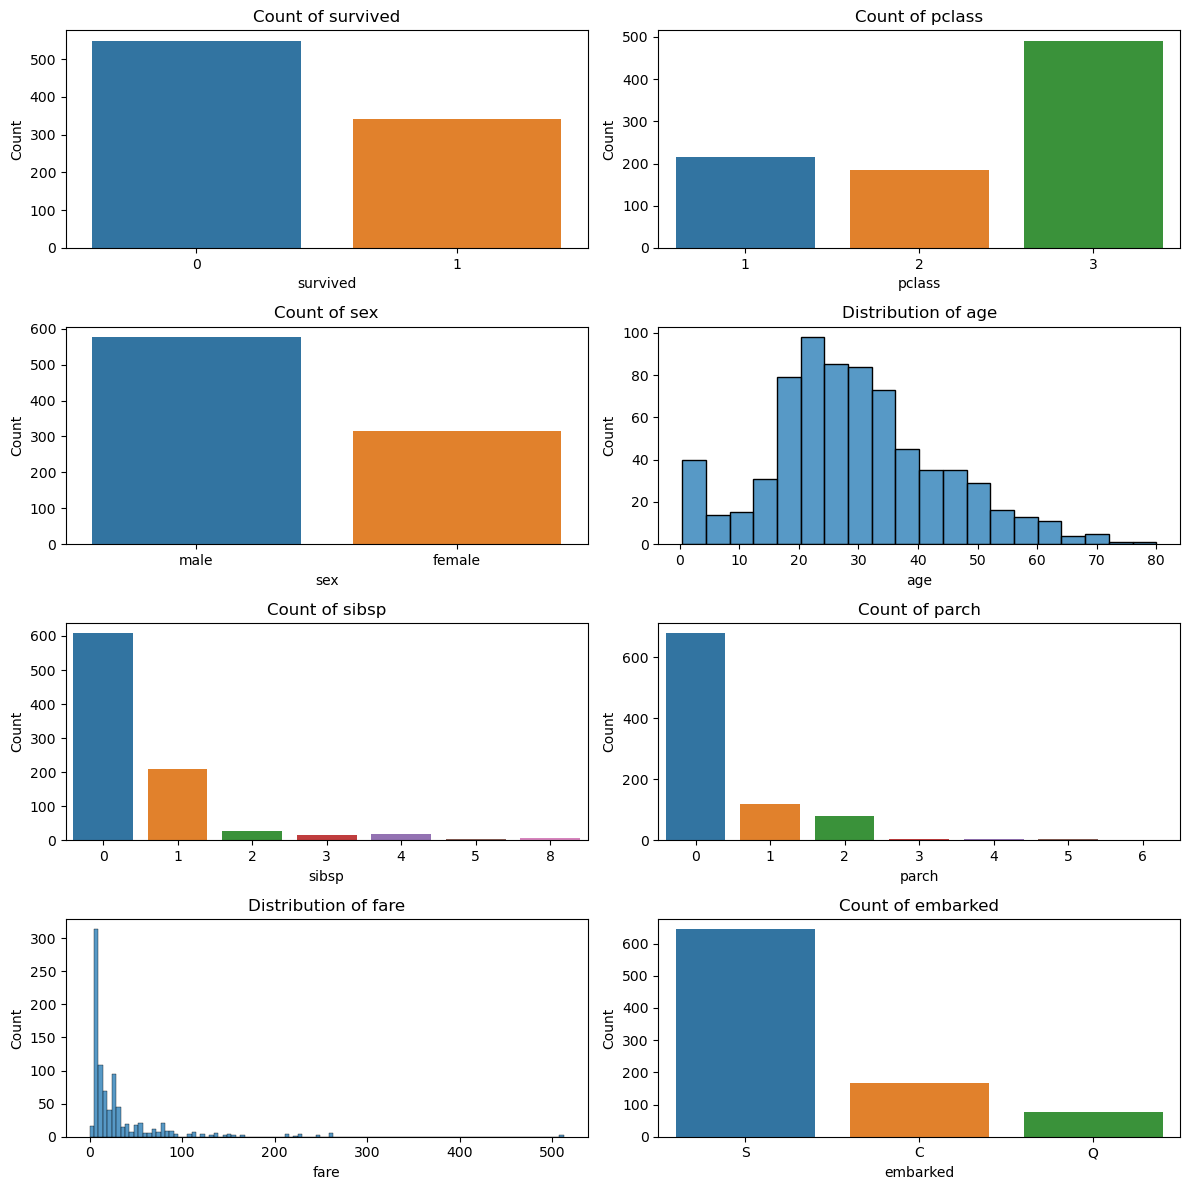

In [281]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

i = 0
for col in df.columns:
    if col not in ['name', 'ticket', 'cabin']:
        if len(df[col].unique()) < 10:
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_title(f"Count of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        else:
            sns.histplot(df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        i += 1

plt.tight_layout()
plt.show()

Построим теперь теже самые графики, только для тестовой выборки и сравним

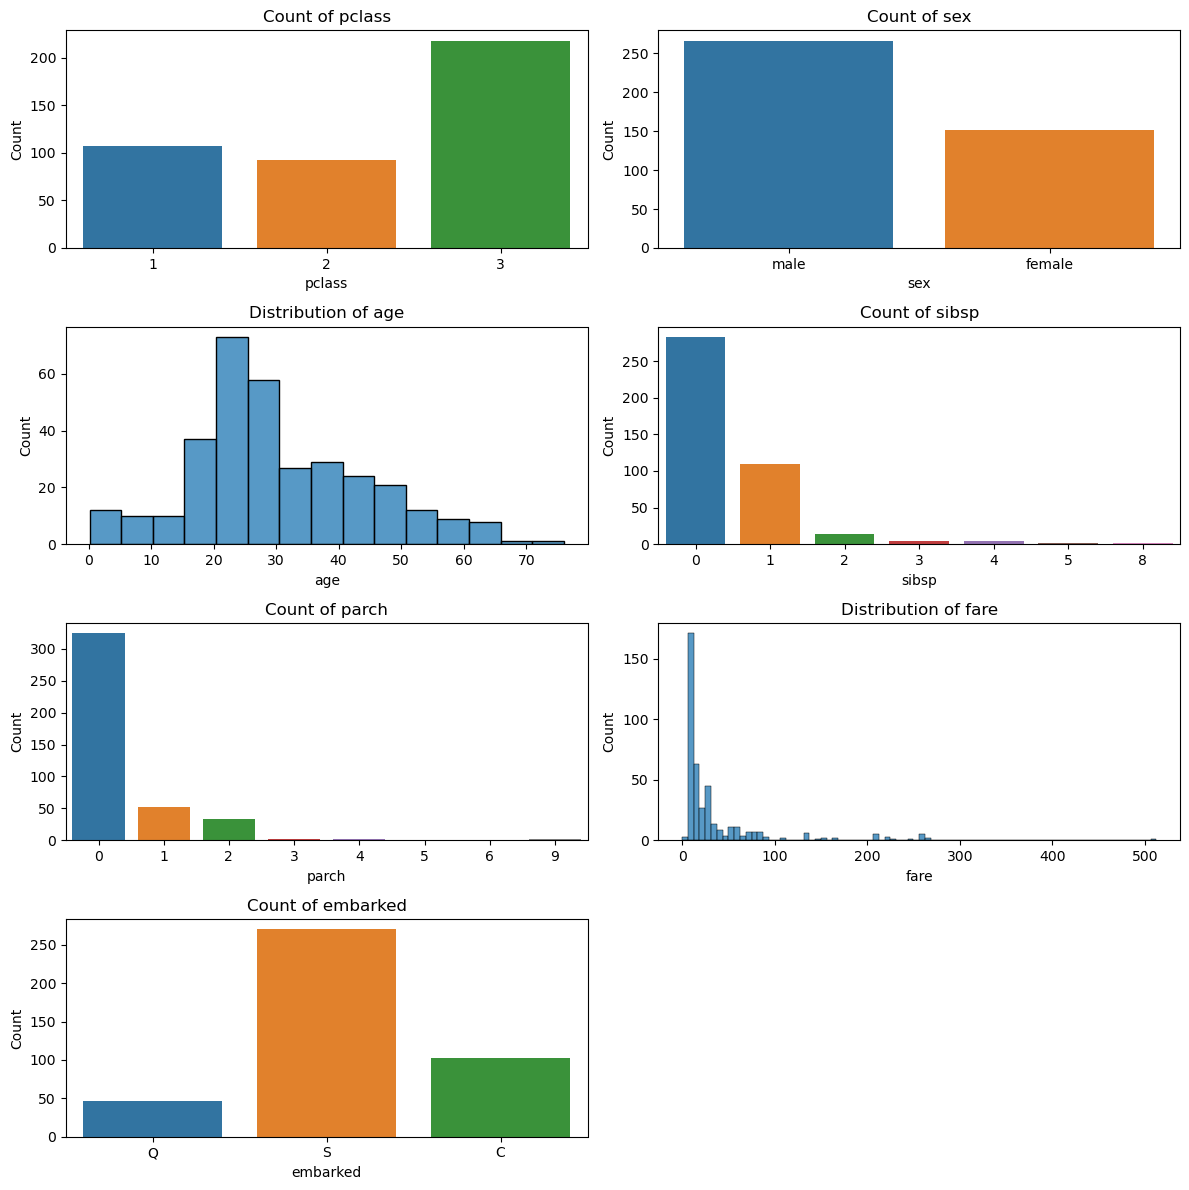

In [282]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

i = 0
for col in test_df.columns:
    if col not in ['name', 'ticket', 'cabin']:
        if len(test_df[col].unique()) < 10:
            sns.countplot(x=col, data=test_df, ax=axes[i])
            axes[i].set_title(f"Count of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        else:
            sns.histplot(test_df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        i += 1

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Видно, что данные на тестовой выборке распределены похоже на тренировочную выборку

На графиках видно, что некоторые значения fare равны 0, что скорее всего является пропуском. Заменим их на медиану по классу

In [283]:
# Заменим значения в fare = 0 на медиану по классу

df['fare'] = df.groupby('pclass')['fare'].transform(lambda x: x.replace(0, x.median()))
test_df['fare'] = test_df.groupby('pclass')['fare'].transform(lambda x: x.replace(0, x.median()))

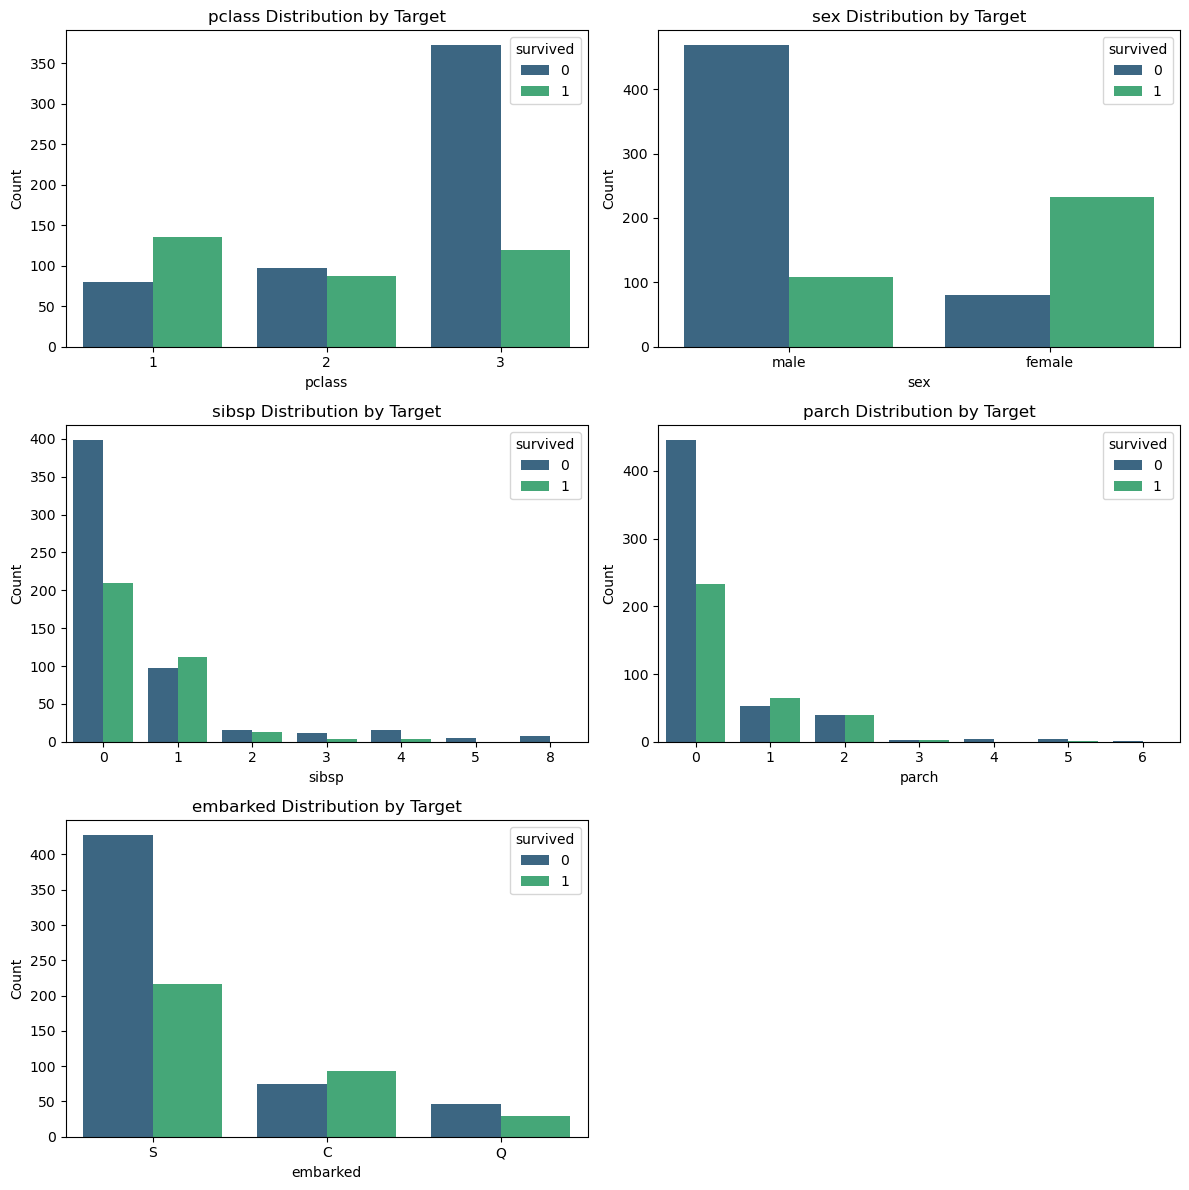

In [284]:
features_to_visualize = [df.columns[i] for i in range(1, len(df.columns)) if len(df[df.columns[i]].unique()) < 10 and df.columns[i] not in ['survived']]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for ax, feature in zip(axs.flatten(), features_to_visualize):
    sns.countplot(data=df, x=feature, hue='survived', palette='viridis', ax=ax)
    ax.set_title(f'{feature} Distribution by Target')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='survived')

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

По последнему графику вижно, что в зависимости от порта отправления просматривается зависимость выживаемости. Но я считаю, что это скорее связано с распределением пассажиров разных классов между этими портами, давайте проверим

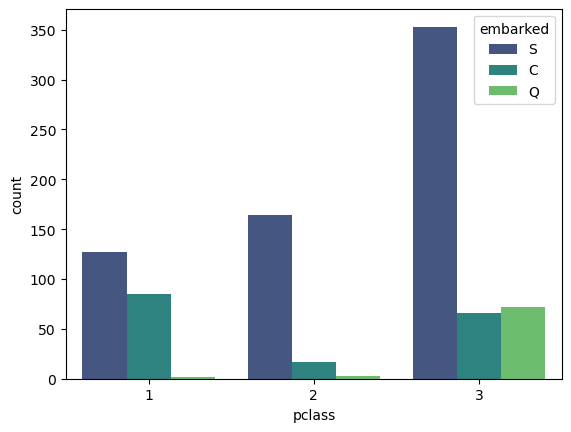

In [285]:
sns.countplot(data=df, x='pclass', hue='embarked', palette='viridis')
ax.set_title(f'pclass Distribution by embarked')
ax.set_xlabel('pclass')
ax.set_ylabel('Count')
ax.legend(title='embarked')
plt.show()

Из данного графика видно, что наше предположение было верным

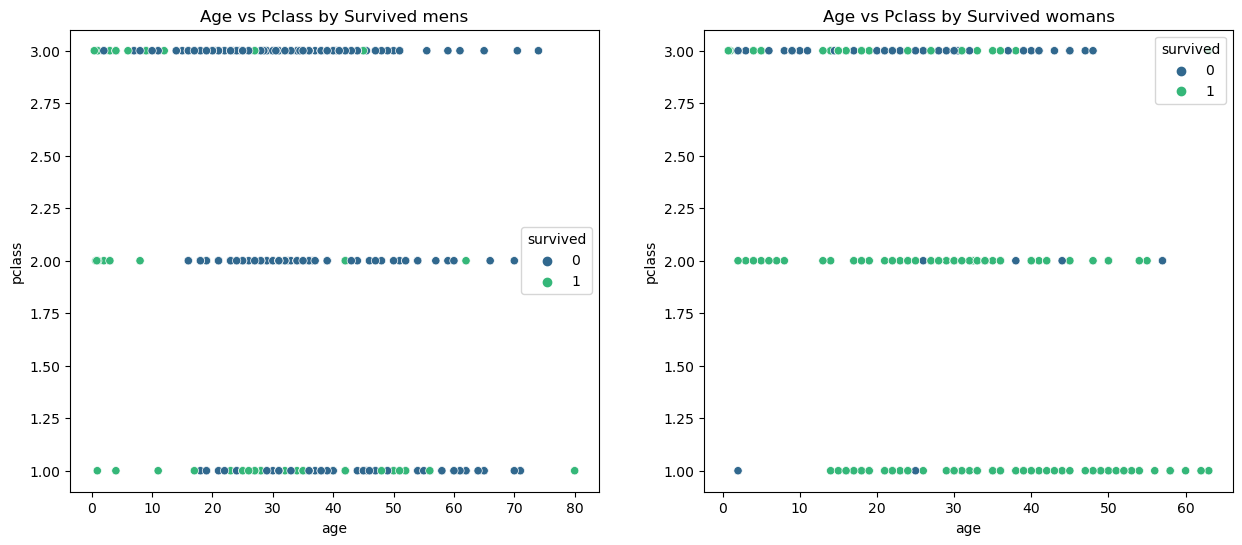

In [286]:
# Посстроим график в координатах возраст и класс билета, где разным цветом будем обозначать выживших и погибших

mens = df[df['sex'] == 'male']
womans = df[df['sex'] == 'female']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.scatterplot(data=mens, x='age', y='pclass', hue='survived', palette='viridis', ax=axs[0])
axs[0].set_title('Age vs Pclass by Survived mens')
sns.scatterplot(data=womans, x='age', y='pclass', hue='survived', palette='viridis', ax=axs[1])
axs[1].set_title('Age vs Pclass by Survived womans')
plt.show()

Из графиков видно, что почти все женщины из первого и второго класса выжили, а из третьего класса - нет. Поэтому добавим новую фичу - женщина из первого или второго класса под названием wom

In [287]:
# добавим новую фичу - женщина из первого или второго класса
df['is_rich_woman'] = ((df['sex'] == 'female') & (df['pclass'] < 3)).astype(int)
test_df['is_rich_woman'] = ((test_df['sex'] == 'female') & (test_df['pclass'] < 3)).astype(int)

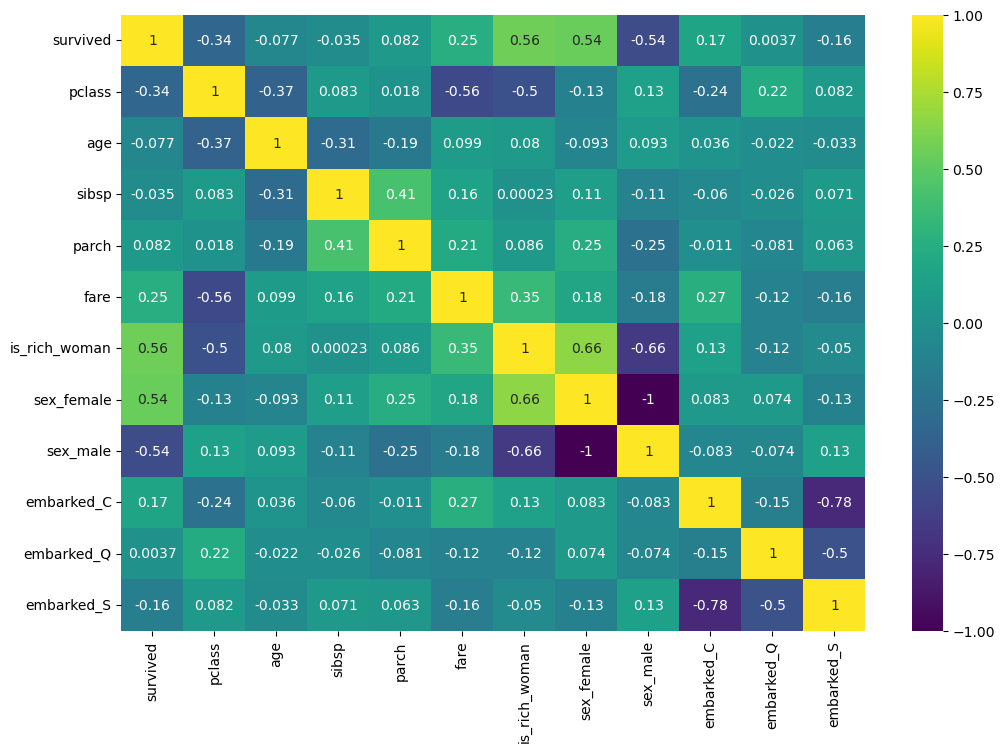

In [288]:
# построим график корреляции

plt.figure(figsize=(12, 8))
df_encoded = pd.get_dummies(df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'is_rich_woman']])
sns.heatmap(df_encoded.corr(), annot=True, cmap='viridis')
plt.show()

Начнем заполнять пропуски. В колонке embarked одно пропущенное замени его наиболее популярным значением 'S' из этого класса. В колонке age заменим пропущенные значения на предсказанные с помощью rf

In [289]:
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
test_df['embarked'].fillna(test_df['embarked'].mode()[0], inplace=True)

In [290]:
test_age = df[df['age'].isna()]
train_age = df[df['age'].notna()]

X = train_age[['pclass', 'sibsp', 'parch', 'fare']]
y = train_age['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X_train, y_train)
pred_median = [y_train.median()] * y_test.shape[0]
print(f"MAE и MSE при подставлении медианы {mean_absolute_error(y_test, pred_median)} {mean_squared_error(y_test, pred_median)}")

pred_rf = model.predict(X_test)
print(f"MAE и MSE при испольщовании rf {mean_absolute_error(y_test, pred_rf)} {mean_squared_error(y_test, pred_rf)}")

MAE и MSE при подставлении медианы 10.804195804195805 185.4090909090909
MAE и MSE при испольщовании rf 9.242458730471526 135.229619901087


Видно что при использовании rf ошибка меньше, чем при подставлении медианы

In [ ]:
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['pclass', 'sibsp', 'parch', 'fare']]).astype(int)
df.loc[df['age'].isna(), 'age'] = predicted_ages

Сделаем тоже самое для тестовых данных

In [292]:
test_age = test_df[test_df['age'].isna()]
train_age = test_df[test_df['age'].notna()]

X = train_age[['pclass', 'sibsp', 'parch', 'fare']]
y = train_age['age']

model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['pclass', 'sibsp', 'parch', 'fare']]).astype(int)
test_df.loc[test_df['age'].isna(), 'age'] = predicted_ages

ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Заметим, что в колонке cabin очень много пропущенных значений, посмотрим на процент выживших с пропущенным значеним в cabin и нет

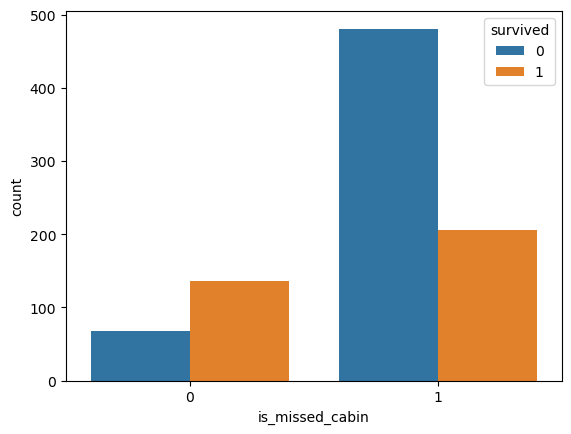

In [ ]:
# посмотрим на процент выживших с пропущенным значеним в cabin и нет

df['is_missed_cabin'] = df['cabin'].isna().astype(int)
test_df['is_missed_cabin'] = test_df['cabin'].isna().astype(int)
sns.countplot(data=df, x='is_missed_cabin', hue='survived')
plt.show()

Заметим, что с пропущенным значеним в cabin выживших меньше, чем с заполненным значением. Рассмотрим строки с пропусками более подробно. Построим графики зависимости выживаемости от пропущенных значений у мужчин и женщин

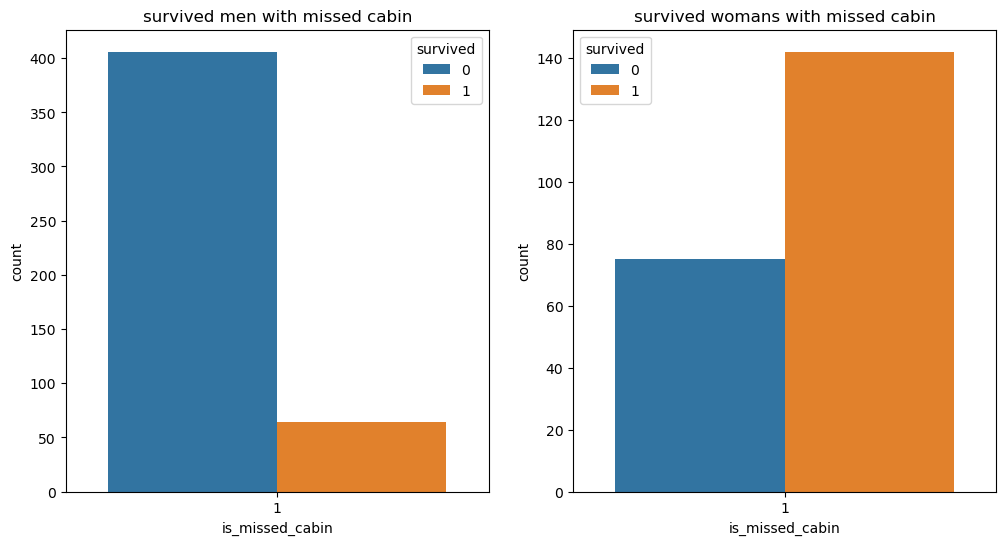

In [ ]:
# Построим графики зависимости выживаемости от пропущенных значений у мужчин и женщин

missed_cabin_male = df[(df['sex'] == 'male') & (df['cabin'].isna())]
missed_cabin_female = df[(df['sex'] == 'female') & (df['cabin'].isna())]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.countplot(data=missed_cabin_male, x='is_missed_cabin', hue='survived', ax=axs[0])
axs[0].set_title(f"survived men with missed cabin")
sns.countplot(data=missed_cabin_female, x='is_missed_cabin', hue='survived', ax=axs[1])
axs[1].set_title(f"survived womans with missed cabin")
plt.show()

Из графиков видно, что пропущенные значения в cabin в основом у мужчин и у них выживаемость меньше, чем у женщин. Поэтому добавим новую фичу is_missed_cabin

In [ ]:
# добавим еще несколько новых фичей

def add_new_features(df):
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['isalone'] = df['family_size'].apply(lambda x: 1 if x == 1 else 0)
    df['farebin'] = pd.qcut(df['fare'], 4, labels=False)
    df['agebin'] = pd.cut(df['age'].astype(int), 5, labels=False)
    df['title'] = df['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df['title'] = df['title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
    return df

df = add_new_features(df)
test_df = add_new_features(test_df)

In [ ]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,is_rich_woman,is_missed_cabin,family_size,isalone,farebin,agebin,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,2,0,0,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,2,0,3,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,1,0,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,2,0,3,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,1,1,2,Mr


Начнем обучение модели, рассмотрим только rf и catboost

In [ ]:
df.drop(columns=['name', 'ticket', 'cabin'], inplace=True)
test_df.drop(columns=['name', 'ticket', 'cabin'], inplace=True)

In [ ]:
df['sex'] = df['sex'].astype('category')
df['embarked'] = df['embarked'].astype('category')
df['title'] = df['title'].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['survived']), df['survived'], test_size=0.3, random_state=42)

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=['sex', 'embarked', 'title'],
        iterations=trial.suggest_int("iterations", 500, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 2, 4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        task_type='CPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=70, n_ei_candidates=13, multivariate=True)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study.optimize(objective, n_trials=300, show_progress_bar=True, n_jobs=-1)

In [ ]:
study.best_params

In [ ]:
df['sex'] = df['sex'].astype('object')
df['embarked'] = df['embarked'].astype('object')
df['title'] = df['title'].astype('object')

In [ ]:
df_dummies = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(columns=['survived']), df_dummies['survived'], test_size=0.3, random_state=42)

In [ ]:
def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("iterations", 500, 1000),
        max_depth=trial.suggest_int("depth", 5, 15),
        criterion=trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=70, n_ei_candidates=13, multivariate=True)
study_rf = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study_rf.optimize(objective, n_trials=300, show_progress_bar=True, n_jobs=-1)

/Users/daniilglazkov/anaconda3/envs/environment_2023_24yml/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/300 [00:00<?, ?it/s]

catboost показал качество лучше, чем rf поэтому используем его

In [ ]:
test_df['sex'] = test_df['sex'].astype('category')
test_df['embarked'] = test_df['embarked'].astype('category')
test_df['title'] = test_df['title'].astype('category')

In [ ]:
model = CatBoostClassifier(**study.best_params, cat_features=['sex', 'embarked', 'title'], verbose=False)
model.fit(df.drop(columns=['survived']), df['survived'])
pred = model.predict(test_df)

In [ ]:
test_df['PassengerId'] = test_passengerid
test_df['Survived'] = pred
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)